<a href="https://colab.research.google.com/github/RIcardoIbarra1695/ejemplo-clase-borrar/blob/main/regresion_lineal/sidney_data_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importando librerías

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


## Leyendo data

In [ ]:

pddf = pd.read_csv('house_price_data.csv')
target = 'price'

In [ ]:
pddf.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [ ]:
#Creamos variables de antiguedad
pddf['year'] = pddf.date.apply(lambda x: int(x[:4]))
pddf['ant_built'] = pddf.year - pddf.yr_built
pddf['ant_renovated'] = pddf.year - pddf.yr_renovated.apply(lambda x: None if x == 0 else x)


<AxesSubplot:>

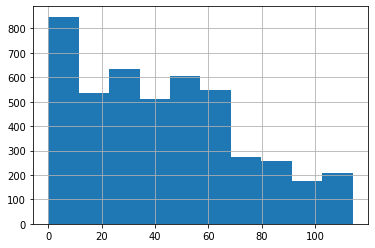

In [ ]:
pddf.ant_built.hist()

In [ ]:
# Este código selecciona las columnas de tipo categóricas
pddf.select_dtypes(include = 'object').columns.tolist()


['date', 'street', 'city', 'statezip', 'country']

In [ ]:

tot_feats = pddf.columns.tolist() #Todas las columnas del dataset
rmv_feats = ['price', 'year', 'yr_built', 'yr_renovated'] #Variables que no nos hacen sentido de incluir
cat_feats = pddf.select_dtypes(include = 'object').columns.tolist() #Variables categóricas

features = list(set(tot_feats) - set(rmv_feats + cat_feats))
data = pddf[features + [target]]


In [ ]:
data.head()

,sqft_above,bathrooms,ant_built,bedrooms,sqft_living,sqft_lot,ant_renovated,waterfront,floors,sqft_basement,condition,view,price
0,1340,1.50,59,3.0,1340,7912,9.0,0,1.5,0,3,0,313000.0
1,3370,2.50,93,5.0,3650,9050,NaN,0,2.0,280,5,4,2384000.0
2,1930,2.00,48,3.0,1930,11947,NaN,0,1.0,0,4,0,342000.0
3,1000,2.25,51,3.0,2000,8030,NaN,0,1.0,1000,4,0,420000.0
4,1140,2.50,38,4.0,1940,10500,22.0,0,1.0,800,4,0,550000.0


## 2. Selección de muestras

In [ ]:
# Muestreo

from sklearn.model_selection import train_test_split

train, test = train_test_split(data, 
                               train_size = 0.7, 
                               random_state = 123)


In [ ]:
print(f"Total data size: {data.shape}")
print(f"Total train size: {train.shape}")
print(f"Total test size: {test.shape}")

Total data size: (4600, 13)
Total train size: (3220, 13)
Total test size: (1380, 13)


## Analisis univariado y tratamiento de datos

In [ ]:
# Creando métricas de las variables

univariate = train.describe().transpose()
univariate.reset_index(inplace = True)
univariate.rename(columns = {'index':'feature',
                             '25%': 'Q1',
                             '50%': 'median',
                             '75%': 'Q3'}, inplace = True)

univariate[['missing_rate']] = 1 - univariate[['count']]/train.shape[0]
univariate.sort_values(by = 'missing_rate', ascending = False, inplace = True)

In [55]:
corr_matrix = train.corr()
corr_matrix.reset_index(inplace = True)
corr_matrix.rename(columns = {'index': 'feature', target: 'correl'}, inplace = True)
univariate_II = pd.merge(univariate, corr_matrix[['feature', 'correl']], on = 'feature', how = 'left') 
univariate_II['correl_abs'] = univariate_II.correl.apply(lambda x: abs(x))
univariate_II.sort_values(by = 'correl_abs', ascending = False, inplace = True)
univariate_II.head(20)

,feature,count,mean,std,min,Q1,median,Q3,max,missing_rate,correl,correl_abs
12,price,3220.0,553651.285167,616584.094342,0.0,326482.142857,466650.00,650000.00,26590000.0,0.000000,1.000000,1.000000
2,sqft_living,3220.0,2146.758075,942.165622,370.0,1480.000000,2000.00,2630.00,13540.0,0.000000,0.359312,0.359312
6,sqft_above,3220.0,1831.705590,853.555534,370.0,1200.000000,1600.00,2300.75,9410.0,0.000000,0.304910,0.304910
1,bathrooms,3220.0,2.169255,0.772937,0.0,1.750000,2.25,2.50,8.0,0.000000,0.277816,0.277816
11,view,3220.0,0.240994,0.777716,0.0,0.000000,0.00,0.00,4.0,0.000000,0.191981,0.191981
8,sqft_basement,3220.0,315.052484,466.482374,0.0,0.000000,0.00,620.00,4820.0,0.000000,0.167796,0.167796
5,bedrooms,3220.0,3.411801,0.908000,0.0,3.000000,3.00,4.00,9.0,0.000000,0.160660,0.160660
3,floors,3220.0,1.510870,0.539988,1.0,1.000000,1.50,2.00,3.5,0.000000,0.122128,0.122128
10,waterfront,3220.0,0.006522,0.080506,0.0,0.000000,0.00,0.00,1.0,0.000000,0.089515,0.089515
7,sqft_lot,3220.0,15021.657764,33898.239766,638.0,5040.000000,7730.00,11071.25,641203.0,0.000000,0.045688,0.045688


<AxesSubplot:xlabel='sqft_living', ylabel='price'>

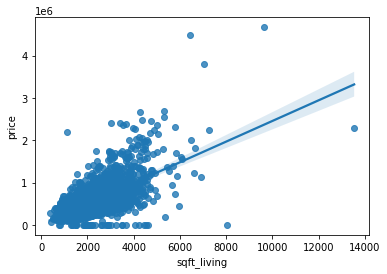

In [58]:
sns.regplot(x = 'sqft_living', y = 'price', data = train.loc[train.price<5000000])

### <b>Pre-selección de variables:</b>
En muchos casos, la cantidad de variables que tendremos que evaluar será tanta que deberemos filtrar aquellas que identiquemos con menor potencial para predecir nuestro target.
Algunos criterios que podemos tomar, son umbrales de correlación y missing rate.

--- 

Ejemplo:

*   Aquellas variables con correlación  < 0.1 se van
*   Aquellas variables con missing rate > 0.9 se van


In [ ]:
feature_prefilter = list(set(univariate_II.loc[univariate_II.correl_abs >= 0.1].loc[univariate_II.missing_rate <= 0.9].feature.tolist()) - set([target])) 


## Analizando el target

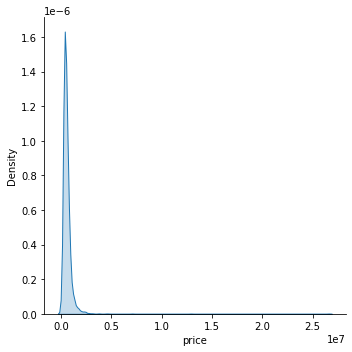

In [ ]:
# Gráfico de distribución 
sns.displot(pddf.price, kind="kde", fill=True)

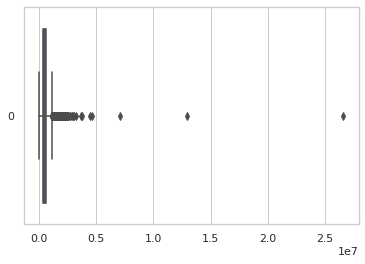

In [ ]:
#Boxplot
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data = pddf.price, orient="h")

In [ ]:
# Tratamiento por z-score
upper_limit = np.mean(pddf.price) + 3*np.std(pddf.price)
lower_limit = np.mean(pddf.price) - 3*np.std(pddf.price)

pddf['price_t'] = pddf.price.apply(lambda x: upper_limit if x > upper_limit
                                        else lower_limit if x < lower_limit else x)

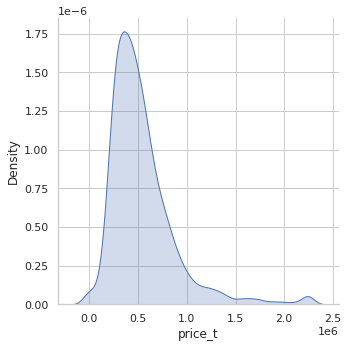

In [ ]:
# Gráfico de distribución 
sns.displot(pddf.price_t, kind="kde", fill=True)

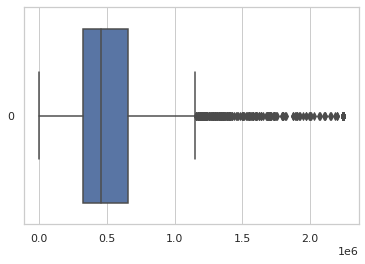

In [ ]:
#Boxplot
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data = pddf.price_t, orient="h")

## 3. Tratamiento de outliers



<img src="https://editor.analyticsvidhya.com/uploads/440971.png" width="500" 
     height="300" > 

In [ ]:
univariate_II.head()


In [ ]:
# Calculando los intervalos Z-score

univariate_II['li_zscore'] = univariate_II['mean'] - 3*univariate_II['std']
univariate_II['ls_zscore'] = univariate_II['mean'] + 3*univariate_II['std']

univariate_II.head() 

In [ ]:
# Tratamiento de outliers por Z-score

def zscore(dataframe, univariate, featuresToTreat):
  for col in featuresToTreat:
    desc = univariate.loc[univariate.feature == col]
    dataframe[col + '_tzscore'] = dataframe[col].apply(lambda x: desc.ls_zscore.values[0] if x > desc.ls_zscore.values[0]
                                                            else desc.li_zscore.values[0] if x < desc.li_zscore.values[0]
                                                            else x)
  return dataframe


In [ ]:
train_I = zscore(train, univariate_II, univariate_II.feature.tolist())
test_I  = zscore(test,  univariate_II, univariate_II.feature.tolist())

In [ ]:
# generación de gráficos

sns.set(rc={'figure.figsize':(6, 4)})
featuresTograph = [x + '_tzscore' for x in feature_prefilter]
i = 0
for col in featuresTograph:
  i += 1
  print(f"graficando {col} ({i}/{len(featuresTograph)})")
  sns.jointplot(x = col, y = target + '_tzscore', data = train_I.sample(500), kind="reg", truncate=False, color="m", height=7).savefig(f"graficos/scatter_{col}.jpg")


## 3. Tratamiento de missigs


In [ ]:
train_II = train_I[[x + '_tzscore' for x in feature_prefilter]].fillna(train_I[[x + '_tzscore' for x in feature_prefilter]].mean())
test_II  = test_I[[x + '_tzscore' for x in feature_prefilter]].fillna(train_I[[x + '_tzscore' for x in feature_prefilter]].mean())


4. Estandarización

In [ ]:
train_III = (train_II - train_II.mean())/train_II.std()
test_III = (test_II - train_II.mean())/train_II.std()


## 5. Modelo de regresión lineal

In [ ]:
train_III

In [ ]:
import statsmodels.api as sm

# Fit and summarize OLS model
mod = sm.OLS(train_I[[target + '_tzscore']], 
             sm.add_constant(train_III))
res = mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:          price_tzscore   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     385.6
Date:                Sun, 19 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:39:46   Log-Likelihood:                -44562.
No. Observations:                3220   AIC:                         8.914e+04
Df Residuals:                    3212   BIC:                         8.919e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  5.408e+

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
variables_mod = list(set(train_III.columns.tolist()) - set(['bathrooms_tzscore', 'sqft_living_tzscore']))

# Fit and summarize OLS model
mod = sm.OLS(train_I[[target + '_tzscore']], sm.add_constant(train_III[variables_mod]))
res = mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:          price_tzscore   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     540.2
Date:                Sun, 19 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:42:23   Log-Likelihood:                -44562.
No. Observations:                3220   AIC:                         8.914e+04
Df Residuals:                    3214   BIC:                         8.917e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  5.408e+

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
variables_mod = list(set(train_III.columns.tolist()) - set(['bathrooms_tzscore', 'sqft_living_tzscore', 'bedrooms_tzscore']))

# Fit and summarize OLS model
mod = sm.OLS(train_I[[target + '_tzscore']], sm.add_constant(train_III[variables_mod]))
res = mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:          price_tzscore   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     654.7
Date:                Sun, 19 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:55:45   Log-Likelihood:                -44585.
No. Observations:                3220   AIC:                         8.918e+04
Df Residuals:                    3215   BIC:                         8.921e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  5.408e+

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
modelo = pd.DataFrame({'coeficiente' : res.params})
modelo.reset_index(inplace = True)
modelo.rename(columns = {'index': 'feature'}, inplace = True)
modelo = modelo.loc[modelo.feature != 'const']
modelo['peso'] = modelo.coeficiente/modelo.coeficiente.sum()
modelo.sort_values(by = 'peso', ascending = False, inplace = True)
modelo


,feature,coeficiente,peso
1,sqft_above_tzscore,177975.504038,0.497172
3,sqft_basement_tzscore,98344.739467,0.274725
2,view_tzscore,62398.625011,0.174310
4,floors_tzscore,19256.615734,0.053793


## 6. Control de correlaciones

In [ ]:
train_III[variables_mod].corr()

,sqft_above_tzscore,view_tzscore,sqft_basement_tzscore,floors_tzscore
sqft_above_tzscore,1.000000,0.136061,-0.116494,0.529192
view_tzscore,0.136061,1.000000,0.294443,0.009110
sqft_basement_tzscore,-0.116494,0.294443,1.000000,-0.287233
floors_tzscore,0.529192,0.009110,-0.287233,1.000000


## 7. Evaluación en test

In [ ]:
train_III[variables_mod]

In [ ]:
train_VI = sm.add_constant(train_III[variables_mod])
test_VI = sm.add_constant(test_III[variables_mod])

train_VI['prediction'] = res.predict(train_VI)
test_VI['prediction'] = res.predict(test_VI)

train_VI[target + '_tzscore'] = train_I[[target + '_tzscore']]
test_VI[target + '_tzscore'] = test_I[[target + '_tzscore']]


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
from sklearn.metrics import r2_score

In [ ]:

print(f'R2 en train: {r2_score(train_VI[target + "_tzscore"], train_VI.prediction)}')
print(f'R2 en test:  {r2_score(test_VI[target + "_tzscore"], test_VI.prediction)}')


R2 en train: 0.4488939611179431
R2 en test:  0.48768660809391395
